In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from ripple_heterogeneity.utils import (
    functions,
    loading,
    batch_analysis,
    add_new_deep_sup,
    custom_plots,
)
from ripple_heterogeneity.assembly import assembly_reactivation,find_sig_assembly
from ripple_heterogeneity.readout import ca1_assembly_downstream_psth, ca1_and_cortex_assemblies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator
import os
from scipy import stats
from itertools import combinations
from scipy import signal
from statannot import add_stat_annotation
from statannotations.Annotator import Annotator
from scipy.ndimage import gaussian_filter1d

functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [62]:
df = pd.read_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv")

region_df = pd.DataFrame()
for basepath in df.basepath:
    brainRegions = loading.load_brain_regions(basepath)
    temp_df = pd.DataFrame()
    temp_df["brainRegions"] = brainRegions.keys()
    temp_df["basepath"] = basepath
    region_df = pd.concat([region_df, temp_df], ignore_index=True)

sessions = region_df[region_df.brainRegions.str.contains("PFC|EC1|EC2|EC3|EC4|EC5|MEC")]
df_sessions = pd.DataFrame()
df_sessions["basepath"] = sessions.basepath.unique()
df_sessions

,basepath
0,Z:\Data\AYAold\AYA7\day19
1,Z:\Data\AYAold\AYA7\day20
2,Z:\Data\AYAold\AYA7\day24
3,Z:\Data\AYAold\AYA7\day25
4,Z:\Data\AYAold\AYA7\day27
...,...
105,Z:\Data\FujisawaS\EE\EE0705fm
106,Z:\Data\FujisawaS\EE\EE0706fm
107,Z:\Data\FujisawaS\EE\EE0708fm
108,Z:\Data\HMC1\day12


## main analysis

In [63]:
save_path = (
    r"Z:\home\ryanh\projects\ripple_heterogeneity\ca1_and_cortex_assemblies_v2"
)

batch_analysis.run(
    sessions,
    save_path,
    ca1_and_cortex_assemblies.run,
    parallel=True,
    overwrite=False,
    verbose=True,
    skip_if_error=False,
)
# load results
results = ca1_and_cortex_assemblies.load_results(save_path)

100%|██████████| 110/110 [02:26<00:00,  1.33s/it]


In [8]:
X = np.random.rand(10,1000)
crosscorrs,pairs = ca1_and_cortex_assemblies.compute_cross_correlogram(X, dt=.002, window=0.5)

ccg_id_df = pd.DataFrame()
ccg_id_df["ref"] = pairs[:, 0]
ccg_id_df["target"] = pairs[:, 1]
ccg_id_df

,ref,target
0,0,1
1,0,2
2,0,3
3,0,4
4,0,5
5,0,6
6,0,7
7,0,8
8,0,9
9,1,2


In [79]:
results["assembly_df_all"]

,patterns,is_member,assembly_n,UID,putativeCellType,brainRegion,deepSuperficial,deepSuperficialDistance,assembly_keep,region,affiliation,basepath
0,0.004338,False,0,59,Pyramidal Cell,CA1,Deep,-194.225944,True,CA1,Deep,Z:\Data\AYAold\AYA7\day19
1,0.135207,False,0,60,Pyramidal Cell,CA1,Deep,-94.225944,True,CA1,Deep,Z:\Data\AYAold\AYA7\day19
2,0.571052,True,0,62,Pyramidal Cell,CA1,Deep,-144.225944,True,CA1,Deep,Z:\Data\AYAold\AYA7\day19
3,0.670564,True,0,64,Pyramidal Cell,CA1,Deep,-94.225944,True,CA1,Deep,Z:\Data\AYAold\AYA7\day19
4,0.197141,False,0,65,Pyramidal Cell,CA1,Deep,-144.225944,True,CA1,Deep,Z:\Data\AYAold\AYA7\day19
...,...,...,...,...,...,...,...,...,...,...,...,...
57519,0.143293,False,7,17,Pyramidal Cell,PFC,Cortical,NaN,True,PFC,Cortex,Z:\Data\ORproject\OR18\day2
57520,0.165164,False,7,18,Pyramidal Cell,PFC,Cortical,NaN,True,PFC,Cortex,Z:\Data\ORproject\OR18\day2
57521,-0.120452,False,7,19,Pyramidal Cell,PFC,Cortical,NaN,True,PFC,Cortex,Z:\Data\ORproject\OR18\day2
57522,-0.039521,False,7,20,Pyramidal Cell,PFC,Cortical,NaN,True,PFC,Cortex,Z:\Data\ORproject\OR18\day2


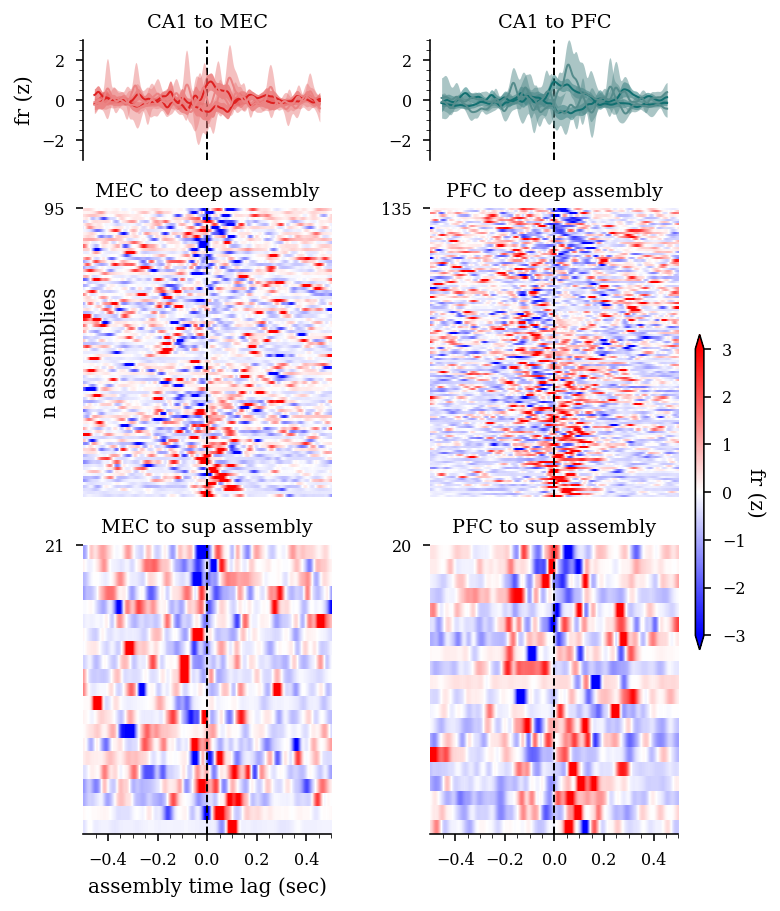

In [69]:
def plot_psth_matrix(
    psth_df, label=None, ax=None, vmax=3, vmin=-3,zscore=True,smooth=True,smooth_sigma=0.02
):

    psth = psth_df.values
    
    psth = psth[:,~np.isnan(psth).any(axis=0)]

    if smooth:
        psth_smooth = gaussian_filter1d(
            psth, np.round(smooth_sigma / np.diff(psth_df.index)[0]), axis=0
        )
    else:
        psth_smooth = psth

    sort_idx = np.argsort(get_center_val(psth_df))

    if ax is None:
        plt.figure()
    ax = plt.gca()

    extent = [psth_df.index.min(), psth_df.index.max(), 0, psth.shape[1]]

    if zscore:
        psth_smooth = stats.zscore(psth_smooth, axis=0)
    sm = ax.imshow(
        psth_smooth[:, sort_idx].T,
        aspect="auto",
        interpolation="nearest",
        extent=extent,
        vmin=vmin,
        vmax=vmax,
        cmap="bwr",
    )

    ax.set_yticks([psth.shape[1]])

    ax.axvline(0, color="k", lw=1, ls="--")
    if label is not None:
        ax.set_title(label, fontsize=12)
    return sm

def confidence_intervals(X,conf=0.95):
    # remove nans
    X = X[np.sum(np.isnan(X),axis=1) == 0,:]
    # compute interval for each column
    interval = [stats.t.interval(conf, len(a) - 1, loc = np.mean(a), scale = stats.sem(a)) for a in X.T]
    interval = np.vstack(interval)
    lower = interval[:,0]
    upper = interval[:,1]
    return lower,upper
    
def std_upper_lower(X):
    upper = np.nanmean(X,axis=1) + np.nanstd(X,axis=1)
    lower = np.nanmean(X,axis=1) - np.nanstd(X,axis=1)
    return lower,upper
    
def get_center_val(psth_df, window=[0,0.1], smooth_sigma=0.02,zscore=True,smooth=True):
    # find cells within region
    psth = psth_df.values
    # standardize psth
    if zscore:
        psth = stats.zscore(psth, axis=0)
    # smooth over time
    if smooth:
        psth_smooth = gaussian_filter1d(
            psth, np.round(smooth_sigma / np.diff(psth_df.index)[0]), axis=0
        )
    else:
        psth_smooth = psth

    # pull out data within time window
    X = psth_smooth[(psth_df.index > window[0]) & (psth_df.index < window[1]), :]
    # find center value of each cell, can be positive or negative, but will be max magnitude
    center_val = [X[np.argmax(np.abs(X[:,i])),i] for i in range(X.shape[1])]
    return np.array(center_val)

def plot_psth_postive_negative(psth_df, group_label, group_colors, ax0, zscore=True, smooth_sigma=0.02,smooth=True):

    center_val = get_center_val(psth_df)

    # plot positive psth responses
    psth = psth_df.values
    psth = psth[:,center_val > 0]

    if smooth:
        psth = gaussian_filter1d(
            psth, np.round(smooth_sigma / np.diff(psth_df.index)[0]), axis=0
        )
    if zscore:
        psth = stats.zscore(psth, axis=0)
    lower,upper= confidence_intervals(psth.T)
    ax0.plot(psth_df.index,np.nanmean(psth,axis=1),color=group_colors[group_label],linewidth=1)
    ax0.fill_between(psth_df.index, lower, upper, color=group_colors[group_label], alpha = .5, linewidth = 0)

    # plot negative psth responses
    psth = psth_df.values
    psth = psth[:,center_val < 0]
    if smooth:
        psth = gaussian_filter1d(
            psth, np.round(smooth_sigma / np.diff(psth_df.index)[0]), axis=0
        )
    if zscore:
        psth = stats.zscore(psth, axis=0)
    lower,upper= confidence_intervals(psth.T)
    ax0.plot(psth_df.index,np.nanmean(psth,axis=1),color=group_colors[group_label],linewidth=1)
    ax0.fill_between(psth_df.index, lower, upper, color=group_colors[group_label], alpha = .5, linewidth = 0)

fig = plt.figure(figsize=functions.set_size('thesis', fraction=1, subplots=(4,2)),constrained_layout=False)
gs = fig.add_gridspec(nrows=5, ncols=2, left=0.05, right=0.75, hspace=0.4, wspace=0.4)

group_colors = {
    "deep_mec": "#de2020",
    "sup_mec": "#eb8383",
    "deep_pfc": "#116f70",
    "sup_pfc": "#568c8c",
}

smooth = True
smooth_sigma=0.01

ax0 = fig.add_subplot(gs[0, 0])
plot_psth_postive_negative(results["deep_mec"], 'deep_mec', group_colors, ax0, smooth=smooth,smooth_sigma=smooth_sigma)
plot_psth_postive_negative(results["sup_mec"], 'sup_mec', group_colors, ax0, smooth=smooth,smooth_sigma=smooth_sigma)

ax1 = fig.add_subplot(gs[0, 1])
plot_psth_postive_negative(results["deep_pfc"], 'deep_pfc', group_colors, ax1, smooth=smooth,smooth_sigma=smooth_sigma)
plot_psth_postive_negative(results["sup_pfc"], 'sup_pfc', group_colors, ax1, smooth=smooth,smooth_sigma=smooth_sigma)

ax2 = fig.add_subplot(gs[1:3,0])
plot_psth_matrix(results["deep_mec"], label=None, ax=ax2, vmax=3, vmin=-3, smooth=smooth,smooth_sigma=smooth_sigma)

ax3 = fig.add_subplot(gs[1:3,1])
plot_psth_matrix(results["deep_pfc"], label=None, ax=ax3, vmax=3, vmin=-3, smooth=smooth,smooth_sigma=smooth_sigma)

ax4 = fig.add_subplot(gs[3:,0])
plot_psth_matrix(results["sup_mec"], label=None, ax=ax4, vmax=3, vmin=-3, smooth=smooth,smooth_sigma=smooth_sigma)

ax5 = fig.add_subplot(gs[3:,1])
sm = plot_psth_matrix(results["sup_pfc"], label=None, ax=ax5, vmax=3, vmin=-3, smooth=smooth,smooth_sigma=smooth_sigma)

axs = [ax0,ax1,ax2,ax3,ax4,ax5]
for i in range(6):
    axs[i].spines["top"].set_visible(False)
    axs[i].spines["right"].set_visible(False)
    axs[i].xaxis.set_minor_locator(AutoMinorLocator())
    axs[i].yaxis.set_minor_locator(AutoMinorLocator())

axs = [ax0,ax1,ax2,ax3]
for i in range(4):
    axs[i].spines["bottom"].set_visible(False)
    axs[i].axes.get_xaxis().set_ticks([])
    axs[i].axvline(0, linestyle = '--', linewidth = 1, alpha = 1, color = 'k',zorder=-100)

axs = [ax2,ax3,ax4,ax5]
for i in range(4):
    axs[i].spines["left"].set_visible(False)

ax0.set_ylabel('fr (z)')

ax4.set_xlabel('assembly time lag (sec)')
ax2.set_ylabel('n assemblies',labelpad=-8)

y_min = -3
y_max = 3
ax0.set_ylim(y_min,y_max)
ax1.set_ylim(y_min,y_max)

cax = plt.axes([0.77, 0.3, 0.01, 0.3])
cbar = plt.colorbar(sm,cax=cax, extend='both')
cbar.set_label('fr (z)', rotation=270, labelpad=10)

ax0.set_title("CA1 to MEC")
ax1.set_title("CA1 to PFC")
ax2.set_title("MEC to deep assembly")
ax3.set_title("PFC to deep assembly")
ax4.set_title("MEC to sup assembly")
ax5.set_title("PFC to sup assembly")

plt.savefig(
    os.path.join(fig_save_path, "cross_corr_assemblies_multi_region.jpeg"),
    dpi=300,
    bbox_inches="tight",
)

In [28]:
results["deep_mec_cc"]

,0,1,2,3,4,5,6,7,8,9,...,85,86,87,88,89,90,91,92,93,94
-0.500,-0.000346,0.000298,0.001710,0.001270,0.000001,-0.000126,-0.000117,0.001840,-0.000495,1.267911e-04,...,0.020020,0.001891,-0.008168,0.000161,-0.001111,-0.003338,-0.001092,0.031868,-0.005509,-0.004386
-0.498,-0.000289,0.000517,0.002108,0.001829,0.000025,-0.000115,-0.000178,0.002615,-0.000490,1.122120e-04,...,0.025486,0.000878,-0.007929,0.000173,-0.001094,-0.004575,-0.001066,0.035825,-0.007201,-0.004113
-0.496,-0.000251,0.000872,0.002302,0.002443,0.000039,-0.000102,-0.000290,0.003408,-0.000462,8.735665e-05,...,0.030144,0.000250,-0.007376,0.000185,-0.001035,-0.005774,-0.000644,0.038083,-0.009615,-0.003560
-0.494,-0.000238,0.001372,0.002229,0.002968,0.000039,-0.000082,-0.000430,0.004037,-0.000419,6.120215e-05,...,0.033295,0.000013,-0.006758,0.000196,-0.000935,-0.006772,0.000269,0.038979,-0.012145,-0.002908
-0.492,-0.000251,0.001973,0.001896,0.003225,0.000019,-0.000057,-0.000549,0.004285,-0.000367,4.353331e-05,...,0.034603,0.000140,-0.006351,0.000208,-0.000801,-0.007426,0.001673,0.039156,-0.014084,-0.002354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.492,0.001203,-0.000119,-0.001115,0.000031,0.000146,0.000091,-0.000494,-0.000307,0.000078,-6.825613e-05,...,-0.000102,0.002542,-0.001583,0.000324,-0.000268,-0.000139,0.000075,0.000141,0.002330,0.004007
0.494,0.001077,-0.000181,-0.001444,0.000102,0.000183,0.000227,-0.000410,-0.000234,0.000063,-4.671269e-05,...,0.000200,0.002299,-0.001417,0.000358,-0.000297,0.000911,0.000064,-0.000046,0.002037,0.005342
0.496,0.000943,-0.000231,-0.001843,0.000170,0.000192,0.000419,-0.000299,-0.000176,0.000050,-2.439804e-05,...,0.000519,0.002015,-0.001181,0.000381,-0.000278,0.001845,0.000057,-0.000224,0.001608,0.006589
0.498,0.000818,-0.000264,-0.002296,0.000224,0.000167,0.000673,-0.000179,-0.000152,0.000040,-3.649770e-07,...,0.000778,0.001715,-0.000874,0.000396,-0.000187,0.002589,0.000051,-0.000368,0.001153,0.007644


In [19]:
import glob
import os
import pickle
sessions = glob.glob(os.path.join(save_path, "*.pkl"))
session = sessions[0]
with open(session, "rb") as f:
    results = pickle.load(f)

<AxesSubplot:>

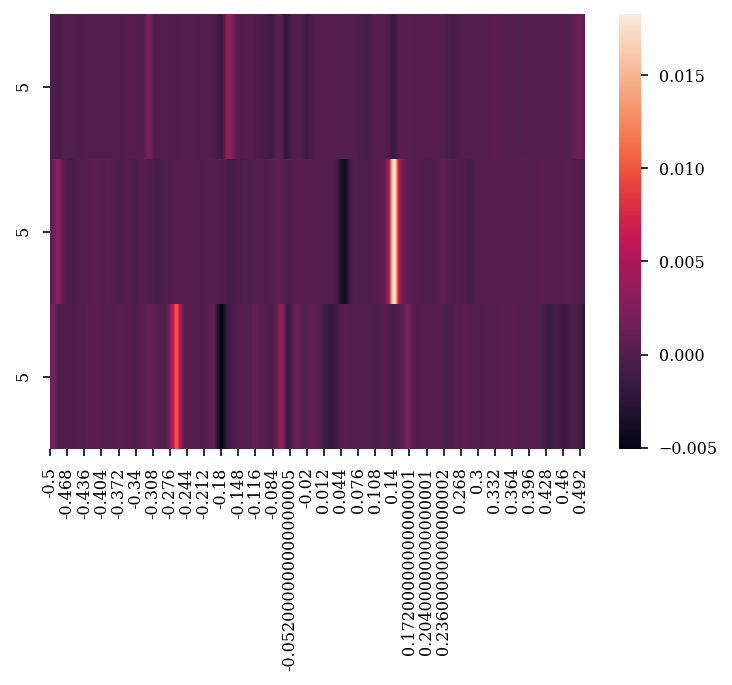

In [64]:

assembly_df = results.get("assembly_df")
crosscorrs = results.get("crosscorrs")

deep_idx = assembly_df[assembly_df.affiliation == "Deep"].assembly_n.unique()
sup_idx = assembly_df[assembly_df.affiliation == "Superficial"].assembly_n.unique()
mec_idx = assembly_df[(assembly_df.affiliation == "Cortex") & assembly_df.brainRegion.str.contains("EC1|EC2|EC3|EC4|EC5|MEC")].assembly_n.unique()
pfc_idx = assembly_df[(assembly_df.affiliation == "Cortex") & assembly_df.brainRegion.str.contains("PFC")].assembly_n.unique()
comparisons = {"deep_idx": deep_idx, "sup_idx": sup_idx, "mec_idx": mec_idx, "pfc_idx": pfc_idx}


deep_mec_cc = pd.DataFrame()
for val in deep_idx:
    deep_mec_cc = pd.concat([deep_mec_cc,crosscorrs[val][mec_idx]],axis=1)

deep_pfc_cc = pd.DataFrame()
for val in deep_idx:
    deep_pfc_cc = pd.concat([deep_pfc_cc,crosscorrs[val][pfc_idx]],axis=1)

sup_mec_cc = pd.DataFrame()
for val in sup_idx:
    sup_mec_cc = pd.concat([sup_mec_cc,crosscorrs[val][mec_idx]],axis=1)

sup_pfc_cc = pd.DataFrame()
for val in sup_idx:
    sup_pfc_cc = pd.concat([sup_pfc_cc,crosscorrs[val][pfc_idx]],axis=1)
# deep_idx,sup_idx,mec_idx,pfc_idx

# pairs = list(combinations(comparisons.keys(), 2))
# for i, j in pairs:
#     for idx in comparisons[i]:
#         print(i,j)
#         try:
#             temp_crosscorrs = pd.concat([temp_crosscorrs,crosscorrs[idx][comparisons[j]]],axis=1)
#         except:
#             pass
# temp_crosscorrs = pd.DataFrame()
# for val in deep_idx:
#     temp_crosscorrs = pd.concat([temp_crosscorrs,crosscorrs[val][mec_idx]],axis=1)
# deep_idx,sup_idx,mec_idx,pfc_idx
sns.heatmap(deep_mec_cc.T)

In [65]:
sup_pfc_cc

""


## testing below

In [171]:
from ripple_heterogeneity.utils import functions, loading, compress_repeated_epochs


def compute_cross_correlogram(X, dt=1, window=0.5):
    """
    Cross-correlate two N-dimensional arrays.
    Input:
        X: N-dimensional array of shape  (n_signals, n_timepoints)
        dt: time step in seconds
        window: window size in seconds, output will be +- window
    Output:
        cross_correlogram: pandas dataframe with pairwise cross-correlogram
    """

    crosscorrs = {}
    pairs = list(combinations(np.arange(X.shape[0]), 2))
    for i, j in pairs:
        auc = signal.correlate(X[i], X[j])
        times = signal.correlation_lags(len(X[i]), len(X[j])) * dt
        # normalize by coeff
        normalizer = np.sqrt((X[i] ** 2).sum(axis=0) * (X[j] ** 2).sum(axis=0))
        auc /= normalizer

        crosscorrs[(i, j)] = pd.Series(index=times, data=auc, dtype="float32")
    crosscorrs = pd.DataFrame.from_dict(crosscorrs)

    if window is None:
        return crosscorrs
    else:
        return crosscorrs[(crosscorrs.index >= -window) & (crosscorrs.index <= window)]


def construct_assembly_df(react):
    # construct dataframe with assembly data
    assembly_df = pd.DataFrame()
    for r in react:
        # find significant assemblies and significant members
        _, _, keep_assembly, is_member = find_sig_assembly.main(r.patterns)
        # get assembly dataframe using code from previous analysis
        results = {"react": r}
        assembly_df_temp = ca1_assembly_downstream_psth.get_assembly_df(
            results, r.patterns, is_member
        )

        # add if the assembly is significant
        keep_assembly_df = pd.DataFrame(
            index=np.arange(r.patterns.shape[0]), data=keep_assembly
        )
        keep_assembly_dict = keep_assembly_df.to_dict()
        assembly_df_temp["assembly_keep"] = assembly_df_temp["assembly_n"]
        assembly_df_temp["assembly_keep"] = assembly_df_temp["assembly_keep"].map(
            keep_assembly_dict[0]
        )

        # add brain region
        assembly_df_temp["region"] = r.brainRegion
        assembly_df = pd.concat([assembly_df, assembly_df_temp], ignore_index=True)

    # add offset to assembly_n
    assem_offset = 0
    for region in assembly_df.region.unique():
        assembly_df.loc[assembly_df.region == region, "assembly_n"] = (
            assembly_df[assembly_df.region == region].assembly_n.values + assem_offset
        )
        assem_offset += assembly_df[assembly_df.region == region].assembly_n.max() + 1
    return assembly_df


def add_affiliation(assembly_df):

    labels = ["Superficial", "Deep"]
    assembly_df["affiliation"] = "unknown"

    # iterate over potential assembly labels
    for n in assembly_df.assembly_n.unique():
        # pull out current assembly and units that assembly members
        cur_assembly = assembly_df[
            (assembly_df.assembly_n == n)
            & (assembly_df.assembly_keep == True)
            & (assembly_df.is_member == True)
        ]
        if cur_assembly.shape[0] == 0:
            continue
        # if there no ca1 in the assembly, assign it to the cortex
        if not (cur_assembly.brainRegion.str.contains("CA1")).all():
            assembly_df.loc[
                (assembly_df.assembly_n == n),
                "affiliation",
            ] = "Cortex"
            continue
        # if there is a ca1 in the assembly, assign it to the deep or superficial
        for label in labels:
            if (cur_assembly.deepSuperficial == label).all():
                assembly_df.loc[
                    (assembly_df.assembly_n == n),
                    "affiliation",
                ] = label
    return assembly_df


def run(
    basepath,
    regions="CA1",  # not used
    target_regions=["CA1", "PFC", "EC1|EC2|EC3|EC4|EC5|MEC"],
    putativeCellType="Pyr",
    weight_dt=0.02,  # dt in seconds for binning st to get weights for each assembly
    verbose=False,  # print out progress
    rip_exp_start=0.05,  # ripple expansion start, in seconds, how much to expand ripples
    rip_exp_stop=0.2,  # ripple expansion stop, in seconds, how much to expand ripples
    min_cells=5,  # minimum number of cells in analysis (n deep, n superficial, n cortex)
):

    epoch_df = loading.load_epoch(basepath)
    epoch_df = compress_repeated_epochs.main(epoch_df, epoch_name="sleep")
    idx = functions.find_pre_task_post(epoch_df.environment)
    if idx is None:
        return None

    cm = pd.DataFrame()
    assembly_act = []
    assembly_act_all = []
    react = []
    for regions in target_regions:

        # initialize session
        m1 = assembly_reactivation.AssemblyReact(
            basepath,
            brainRegion=regions,
            putativeCellType=putativeCellType,
            weight_dt=weight_dt,
        )

        # load data
        m1.load_data()

        # restrict to pre/task/post epochs
        m1.restrict_epochs_to_pre_task_post()

        if m1.st.n_active < min_cells:
            continue

        # detect assemblies during the task
        m1.get_weights(m1.epochs[1])

        if len(m1.patterns) == 0:
            print("No patterns found")
            continue

        # extend ripples to include some extra time
        m1.ripples = m1.ripples.expand(rip_exp_start, direction="start")
        m1.ripples = m1.ripples.expand(rip_exp_stop, direction="stop")
        ac = m1.get_assembly_act(epoch=m1.ripples[m1.epochs[2]])

        assembly_act.append(ac)
        assembly_act_all.append(ac.data)
        cm = pd.concat([cm, m1.cell_metrics], ignore_index=True)
        react.append(m1)

    assembly_act_all = np.vstack(assembly_act_all)

    crosscorrs = compute_cross_correlogram(assembly_act_all, dt=m1.z_mat_dt)

    assembly_df = construct_assembly_df(react)

    assembly_df = add_affiliation(df)

    # deep_idx = assembly_df[assembly_df.affiliation == "Deep"].assembly_n.unique()
    # cortex_idx = assembly_df[assembly_df.affiliation == "Cortex"].assembly_n.unique()
    # # temp_crosscorrs = crosscorrs.loc[deep_idx,cortex_idx]
    # temp_crosscorrs = pd.DataFrame()
    # for val in deep_idx:
    #     temp_crosscorrs = pd.concat([temp_crosscorrs,crosscorrs[val][cortex_idx]],axis=1)
    results = {
        "assembly_df": assembly_df,
        "crosscorrs": crosscorrs,
        "assembly_act": assembly_act,
        "assembly_act_all": assembly_act_all,
        "cell_metrics": cm,
        "react": react,
    }
    return results


assembly_act, assembly_act_all, cm, react, crosscorrs = run(
    r"Z:\Data\AYAold\AYA7\day20"
)


In [199]:
from ripple_heterogeneity.readout import ca1_assembly_downstream_psth

assembly_df = pd.DataFrame()
for r in react:
    _, _, keep_assembly, is_member = find_sig_assembly.main(
        r.patterns
    )
    results = {"react": r}
    assembly_df_temp = ca1_assembly_downstream_psth.get_assembly_df(results, r.patterns, is_member)

    keep_assembly_df = pd.DataFrame(index=np.arange(r.patterns.shape[0]), data=keep_assembly)
    keep_assembly_dict = keep_assembly_df.to_dict()
    assembly_df_temp["assembly_keep"] = assembly_df_temp["assembly_n"]
    assembly_df_temp["assembly_keep"] = assembly_df_temp["assembly_keep"].map(keep_assembly_dict[0])

    assembly_df_temp["region"] = r.brainRegion
    assembly_df = pd.concat([assembly_df, assembly_df_temp], ignore_index=True)

# add offset to assembly_n
assem_offset = 0
for region in assembly_df.region.unique():
    assembly_df.loc[assembly_df.region == region,"assembly_n"] = assembly_df[assembly_df.region == region].assembly_n.values + assem_offset
    assem_offset += assembly_df[assembly_df.region == region].assembly_n.max() + 1
assembly_df

,patterns,is_member,assembly_n,UID,putativeCellType,brainRegion,deepSuperficial,deepSuperficialDistance,assembly_keep,region
0,0.082100,False,0,44,Pyramidal Cell,CA1,Deep,-122.786595,True,CA1
1,0.054394,False,0,52,Pyramidal Cell,CA1,Deep,-122.786595,True,CA1
2,-0.073635,False,0,53,Pyramidal Cell,CA1,Deep,-172.786595,True,CA1
3,-0.120725,False,0,55,Pyramidal Cell,CA1,Deep,-122.786595,True,CA1
4,-0.150020,False,0,56,Pyramidal Cell,CA1,Deep,-72.786595,True,CA1
...,...,...,...,...,...,...,...,...,...,...
371,-0.017335,False,11,161,Pyramidal Cell,MEC,Deep,-865.793403,True,EC1|EC2|EC3|EC4|EC5|MEC
372,-0.040179,False,11,162,Pyramidal Cell,MEC,Deep,-1765.793403,True,EC1|EC2|EC3|EC4|EC5|MEC
373,-0.361362,True,11,163,Pyramidal Cell,MEC,Deep,-1315.793403,True,EC1|EC2|EC3|EC4|EC5|MEC
374,0.014025,False,11,164,Pyramidal Cell,MEC,Deep,-915.793403,True,EC1|EC2|EC3|EC4|EC5|MEC


In [214]:
labels = ["Superficial", "Deep"]
assembly_df["affiliation"] = "unknown"

# iterate over potential assembly labels
for n in assembly_df.assembly_n.unique():
    # pull out current assembly and units that assembly members
    cur_assembly = assembly_df[
        (assembly_df.assembly_n == n)
        & (assembly_df.assembly_keep == True)
        & (assembly_df.is_member == True)
    ]
    if cur_assembly.shape[0] == 0:
        continue
    # if there no ca1 in the assembly, assign it to the cortex
    if not (cur_assembly.brainRegion.str.contains("CA1")).all():
        assembly_df.loc[
            (assembly_df.assembly_n == n),
            "affiliation",
        ] = "Cortex"
        continue
    # if there is a ca1 in the assembly, assign it to the deep or superficial
    for label in labels:
        if (cur_assembly.deepSuperficial == label).all():
            assembly_df.loc[
                (assembly_df.assembly_n == n),
                "affiliation",
            ] = label
assembly_df


,patterns,is_member,assembly_n,UID,putativeCellType,brainRegion,deepSuperficial,deepSuperficialDistance,assembly_keep,region,affiliation
0,0.082100,False,0,44,Pyramidal Cell,CA1,Deep,-122.786595,True,CA1,Deep
1,0.054394,False,0,52,Pyramidal Cell,CA1,Deep,-122.786595,True,CA1,Deep
2,-0.073635,False,0,53,Pyramidal Cell,CA1,Deep,-172.786595,True,CA1,Deep
3,-0.120725,False,0,55,Pyramidal Cell,CA1,Deep,-122.786595,True,CA1,Deep
4,-0.150020,False,0,56,Pyramidal Cell,CA1,Deep,-72.786595,True,CA1,Deep
...,...,...,...,...,...,...,...,...,...,...,...
371,-0.017335,False,11,161,Pyramidal Cell,MEC,Deep,-865.793403,True,EC1|EC2|EC3|EC4|EC5|MEC,Cortex
372,-0.040179,False,11,162,Pyramidal Cell,MEC,Deep,-1765.793403,True,EC1|EC2|EC3|EC4|EC5|MEC,Cortex
373,-0.361362,True,11,163,Pyramidal Cell,MEC,Deep,-1315.793403,True,EC1|EC2|EC3|EC4|EC5|MEC,Cortex
374,0.014025,False,11,164,Pyramidal Cell,MEC,Deep,-915.793403,True,EC1|EC2|EC3|EC4|EC5|MEC,Cortex


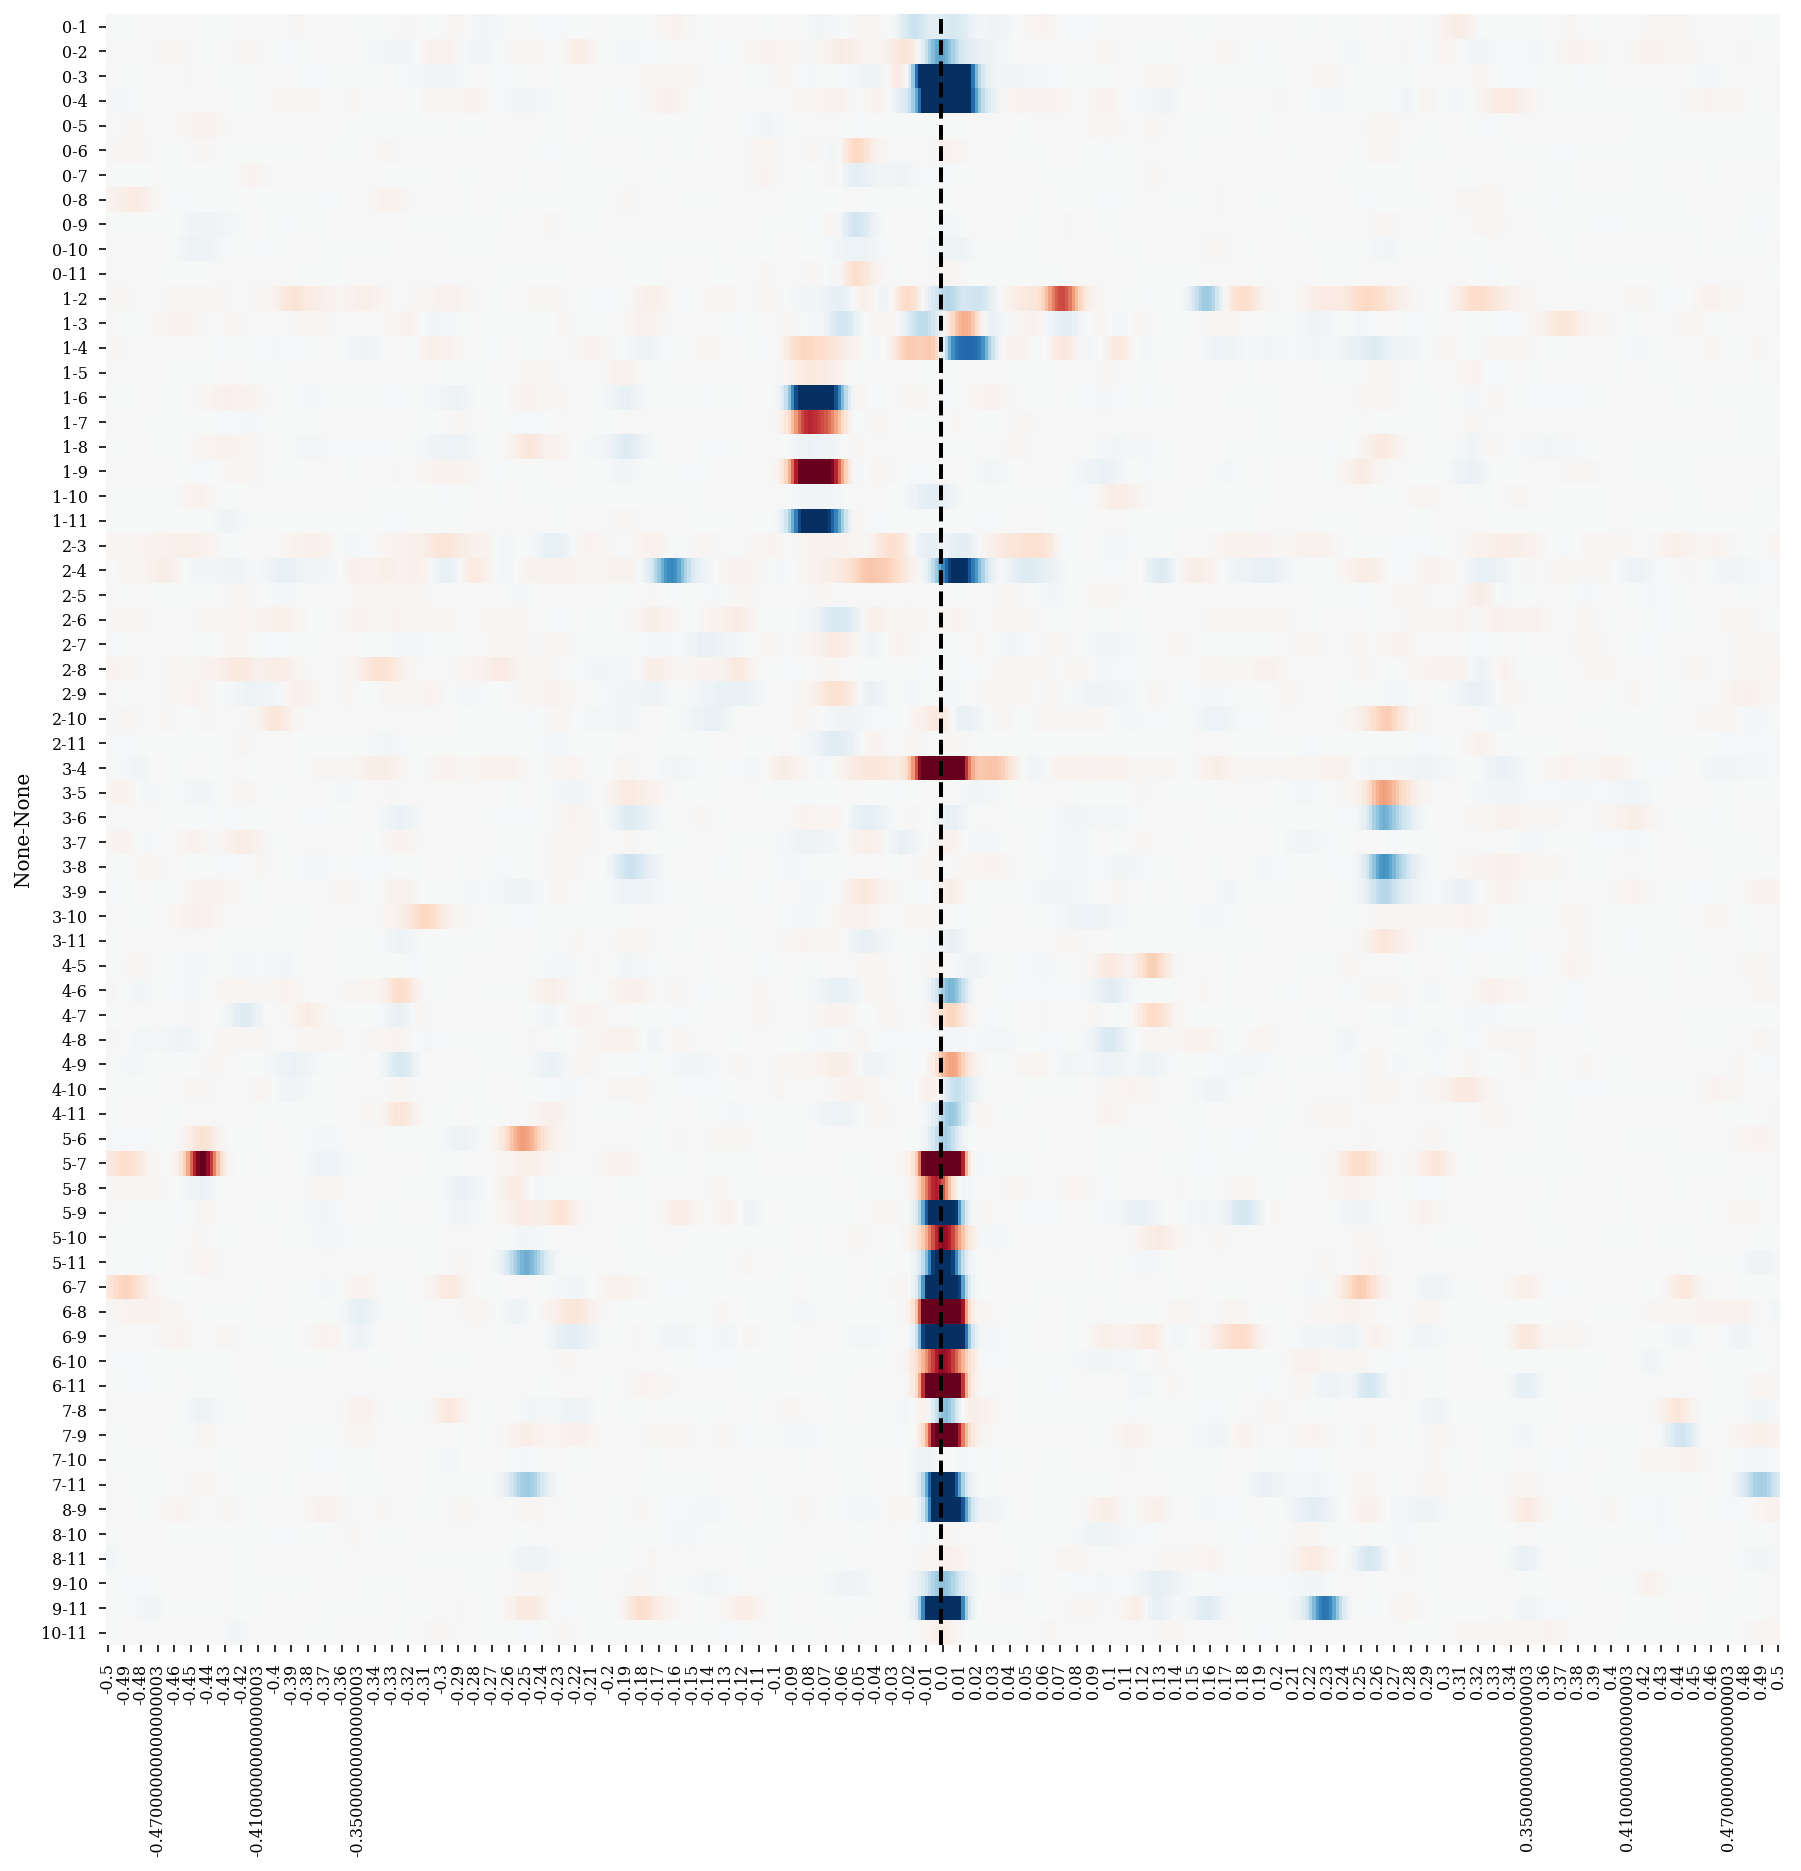

In [239]:
plt.figure(figsize=(15, 15))
sns.heatmap(crosscorrs.T,vmax=.1,vmin=-.1,cmap="RdBu_r",cbar=False)
plt.axvline(np.where(crosscorrs.index == 0)[0],color="k",linewidth=2,linestyle="--")

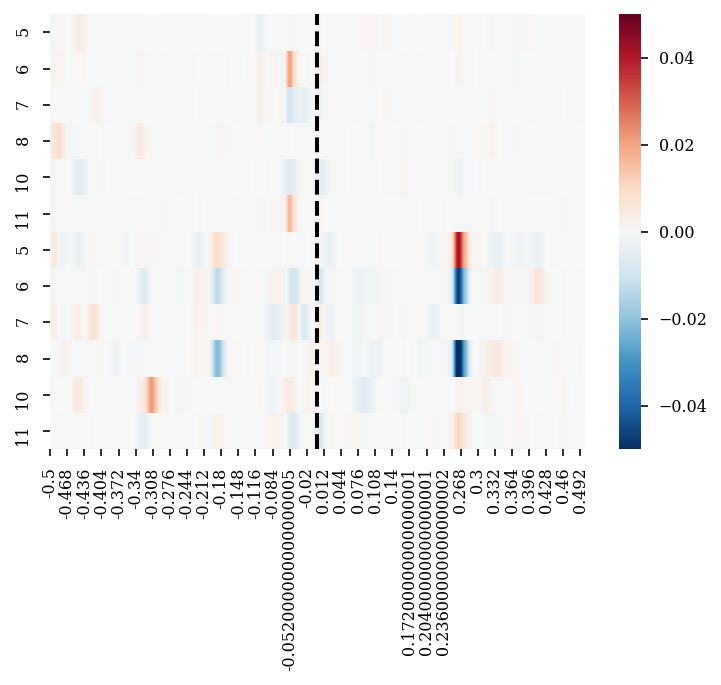

In [304]:
deep_idx = assembly_df[assembly_df.affiliation == "Deep"].assembly_n.unique()
cortex_idx = assembly_df[assembly_df.affiliation == "Cortex"].assembly_n.unique()

# temp_crosscorrs = crosscorrs.loc[deep_idx,cortex_idx]
temp_crosscorrs = pd.DataFrame()

for val in deep_idx:
    temp_crosscorrs = pd.concat([temp_crosscorrs,crosscorrs[val][cortex_idx]],axis=1)

sns.heatmap(temp_crosscorrs.T,vmax=.05,vmin=-.05,cmap="RdBu_r",cbar=True)
plt.axvline(np.where(crosscorrs.index == 0)[0],color="k",linewidth=2,linestyle="--")

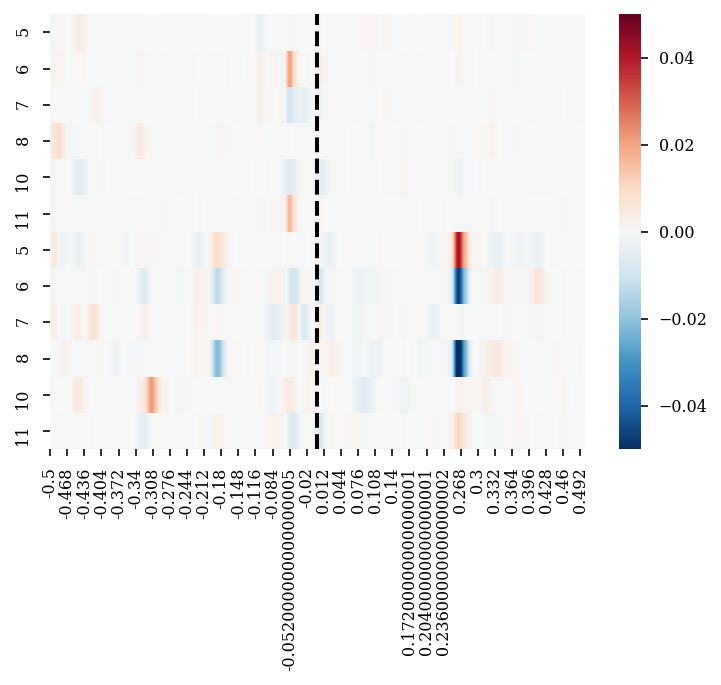

In [285]:
# sns.heatmap(temp_crosscorrs.T)

sns.heatmap(temp_crosscorrs.T,vmax=.05,vmin=-.05,cmap="RdBu_r",cbar=True)
plt.axvline(np.where(crosscorrs.index == 0)[0],color="k",linewidth=2,linestyle="--")

In [260]:
deep_idx = assembly_df[assembly_df.affiliation == "Deep"].assembly_n.unique()

for val in crosscorrs[deep_idx]:
    print(val)


AttributeError: 'tuple' object has no attribute 'shape'

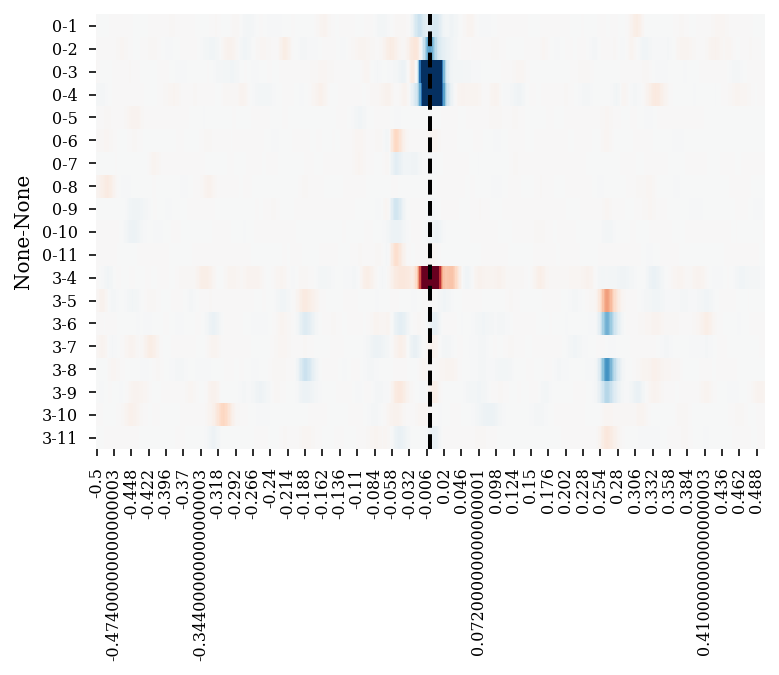

In [307]:
# sns.heatmap(crosscorrs[assembly_df[assembly_df.affiliation == "Deep"].assembly_n.unique()].T)
# cortex_idx = assembly_df[assembly_df.affiliation == "Cortex"].assembly_n.unique()
deep_idx = assembly_df[assembly_df.affiliation == "Deep"].assembly_n.unique()
sns.heatmap(crosscorrs[deep_idx].T,vmax=.1,vmin=-.1,cmap="RdBu_r",cbar=False)
plt.axvline(np.where(crosscorrs.index == 0)[0],color="k",linewidth=2,linestyle="--")

<AxesSubplot:>

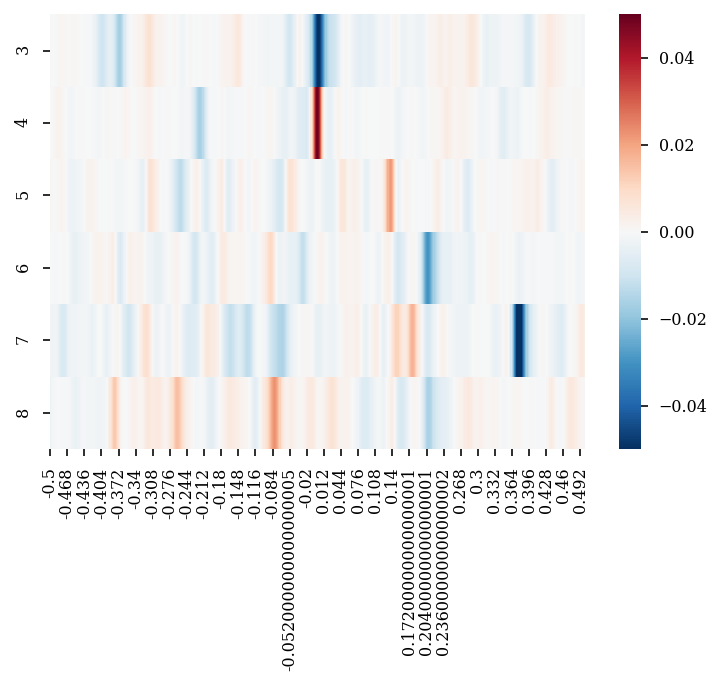

In [105]:
sns.heatmap(crosscorrs[2].T, cmap="RdBu_r", vmin=-.05, vmax=.05)
# plt.axvline(0, color="k", linewidth=0.5)

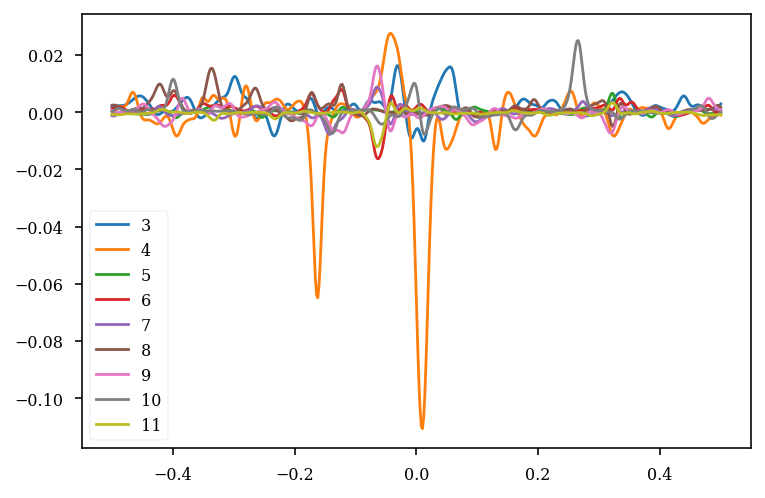

In [308]:
# sns.heatmap(crosscorrs[0][idx].T)

# plt.plot(crosscorrs.index,crosscorrs[2])
crosscorrs[2].plot()
# plt.legend()
# lag = lags[idx][np.argmax(crosscorrs[0][idx].values,axis=0)]
# for l in lag:
#     plt.axvline(l,color='r')
plt.show()

In [80]:
signal_df = pd.DataFrame()
signal_df["ca1_act_1"] = assembly_act[0][m1.epochs[1:]].data[0]
signal_df["ca1_act_2"] = assembly_act[0][m1.epochs[1:]].data[1]
signal_df["ca1_act_3"] = assembly_act[0][m1.epochs[1:]].data[2]
signal_df["ca1_act_4"] = assembly_act[0][m1.epochs[1:]].data[3]
signal_df["ca1_act_5"] = assembly_act[0][m1.epochs[1:]].data[4]

signal_df["pfc_act_1"] = assembly_act[1][m1.epochs[1:]].data[0]
signal_df["pfc_act_2"] = assembly_act[1][m1.epochs[1:]].data[1]
signal_df["pfc_act_3"] = assembly_act[1][m1.epochs[1:]].data[2]
signal_df["pfc_act_4"] = assembly_act[1][m1.epochs[1:]].data[3]

signal_df_cor = signal_df.corr()

<AxesSubplot:>

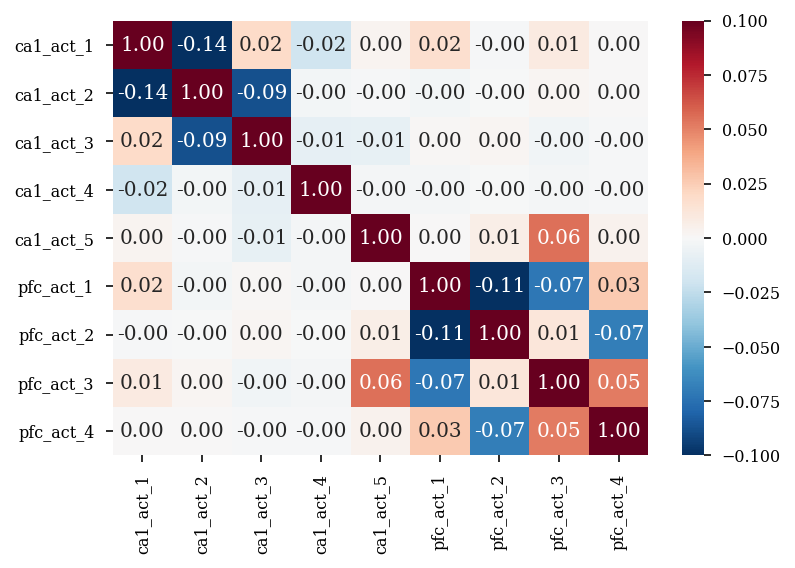

In [82]:
sns.heatmap(signal_df_cor,annot=True, fmt=".2f", cmap="RdBu_r",vmax=0.1, vmin=-0.1)

<AxesSubplot:>

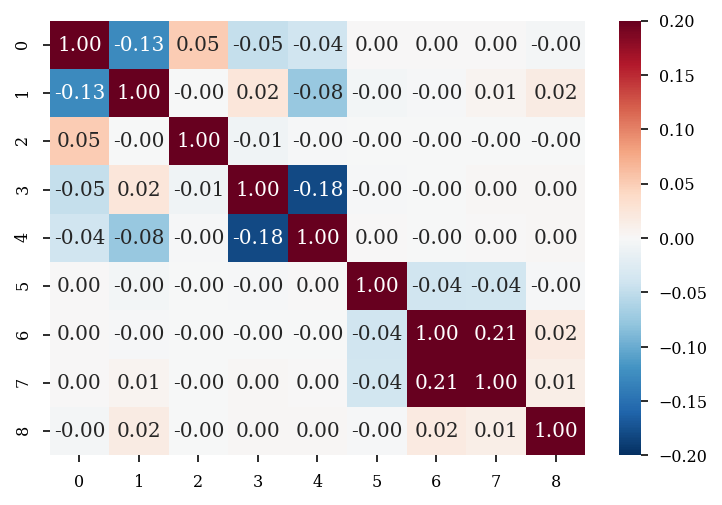

In [62]:
cor_mat = np.corrcoef(assembly_act[0].data,assembly_act[1].data)
sns.heatmap(cor_mat, annot=True, fmt=".2f", cmap="RdBu_r",vmax=0.2, vmin=-0.2)

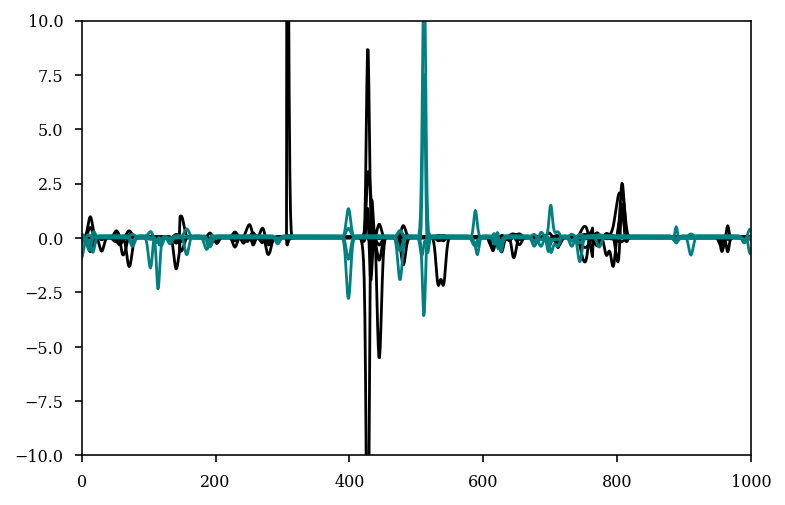

In [54]:
plt.plot(assembly_act[0].data.T,color="k")
plt.plot(assembly_act[1].data.T,color="teal")
plt.xlim(0,1000)
plt.ylim(-10,10)
plt.show()

In [129]:
np.max(lags * 0.002)/60

# assembly_act

49.950633333333336

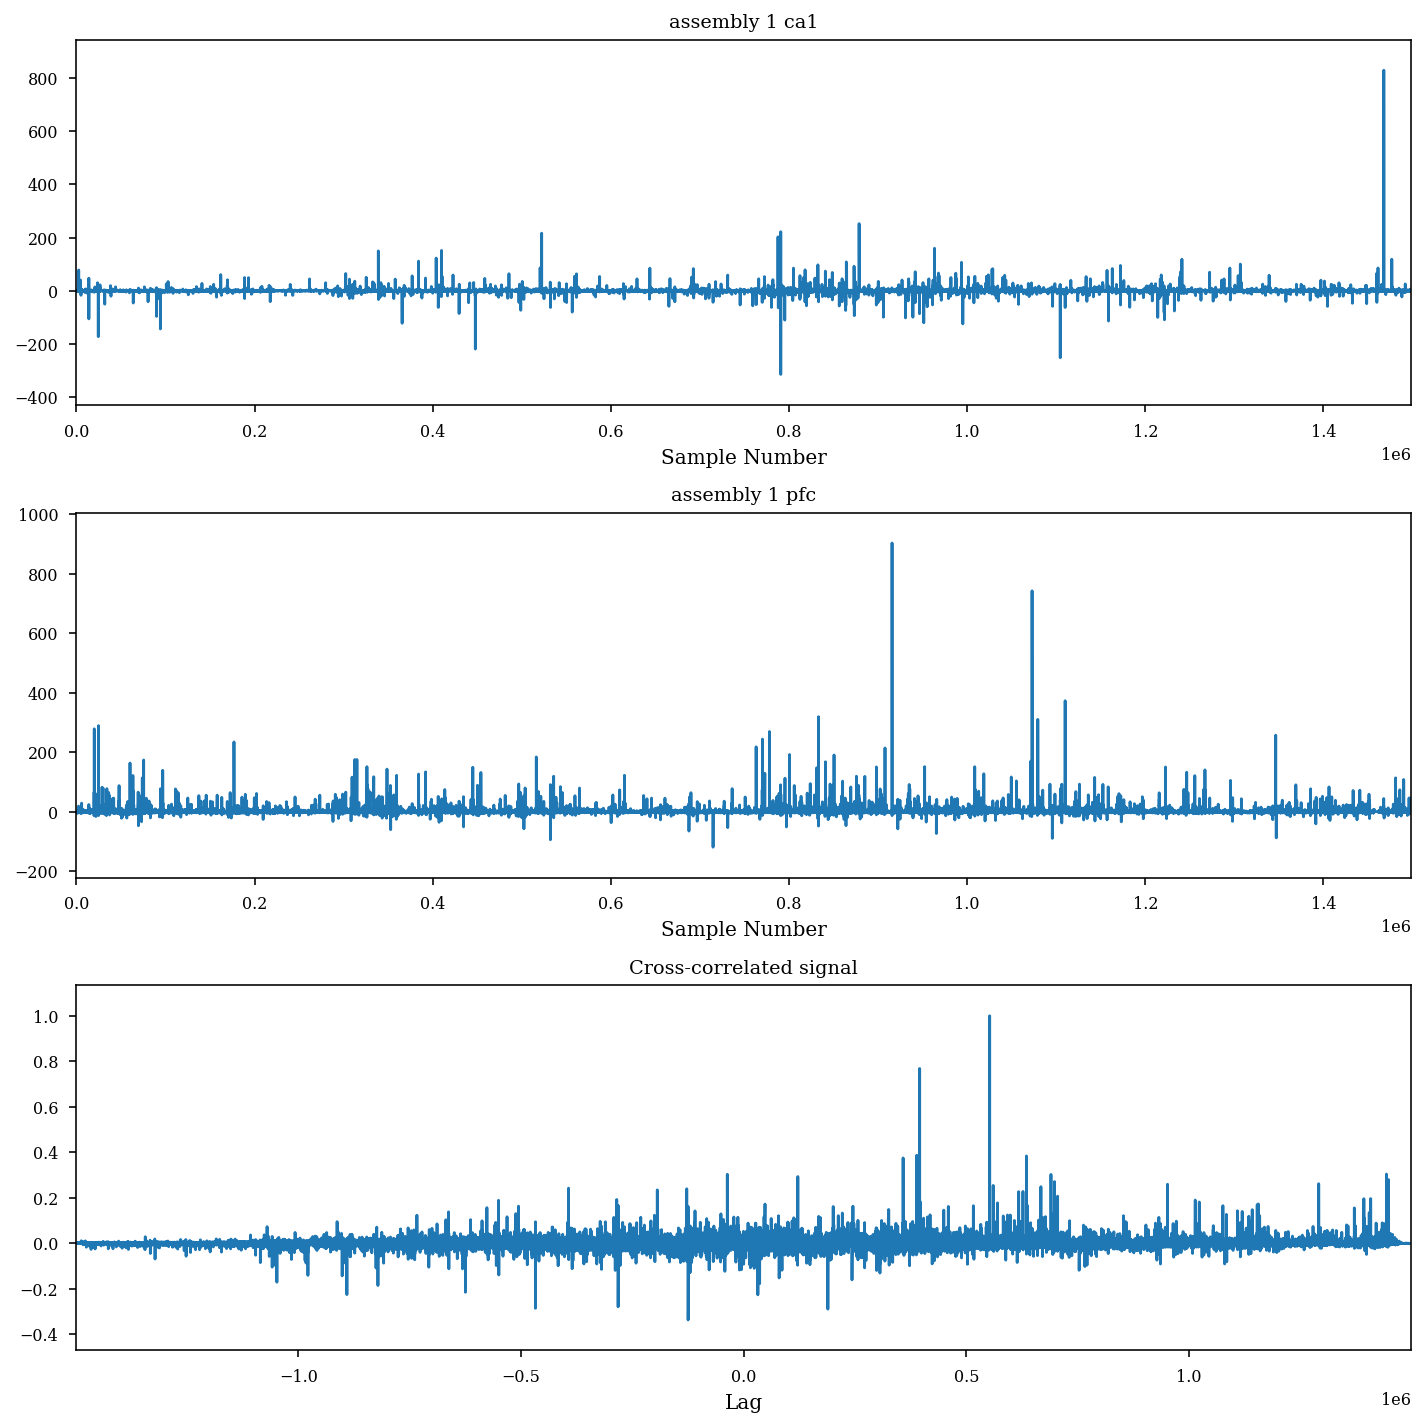

In [95]:
from scipy import signal
corr = signal.correlate(assembly_act[0].data[0], assembly_act[1].data[0])
lags = signal.correlation_lags(len(assembly_act[0].data[0]), len(assembly_act[1].data[0]))
corr /= np.max(corr)


fig, (ax_orig, ax_noise, ax_corr) = plt.subplots(3, 1, figsize=(10, 10))
ax_orig.plot(assembly_act[0].data[0])
ax_orig.set_title('assembly 1 ca1')
ax_orig.set_xlabel('Sample Number')
ax_noise.plot(assembly_act[1].data[0])
ax_noise.set_title('assembly 1 pfc')
ax_noise.set_xlabel('Sample Number')
ax_corr.plot(lags, corr)
ax_corr.set_title('Cross-correlated signal')
ax_corr.set_xlabel('Lag')
ax_orig.margins(0, 0.1)
ax_noise.margins(0, 0.1)
ax_corr.margins(0, 0.1)
fig.tight_layout()
plt.show()

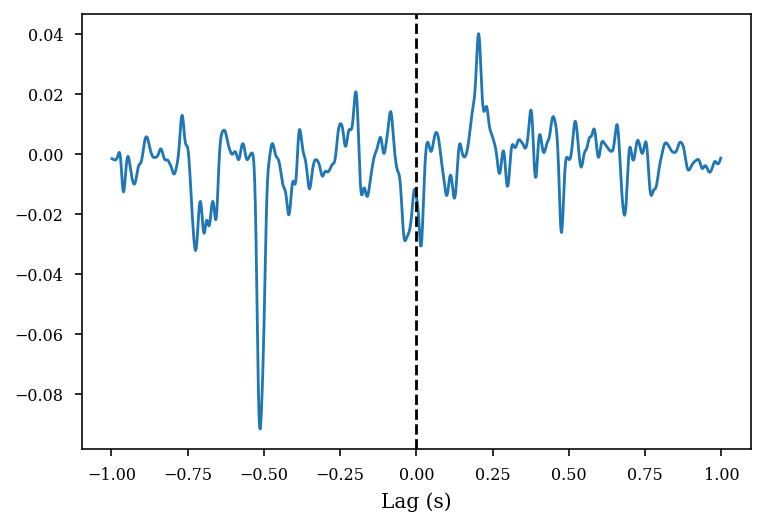

In [99]:
window = 1 # seconds
dt = 0.002
idx = (lags > -window*1/dt) & (lags < window*1/dt)
plt.plot(lags[idx]*dt, corr[idx])
plt.axvline(0, color='black', linestyle='--')
plt.xlabel('Lag (s)')
plt.axis('tight')
plt.show()